In [1]:
import numpy
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

### 1. Load Test and Train Files

In [2]:
files_train = 0
files_validation = 0

cwd = os.getcwd()
folder = 'train_data/train'
for sub_folder in os.listdir(folder):
    path, dirs, files = next(os.walk(os.path.join(folder,sub_folder)))
    files_train += len(files)


folder = 'train_data/test'
for sub_folder in os.listdir(folder):
    path, dirs, files = next(os.walk(os.path.join(folder,sub_folder)))
    files_validation += len(files)

print(files_train,files_validation)

381 164


### 2. Set key parameters

In [3]:
img_width, img_height = 48, 48
train_data_dir = "train_data/train"
validation_data_dir = "train_data/test"
nb_train_samples = files_train
nb_validation_samples = files_validation
batch_size = 32
epochs = 15
num_classes = 2

### 3. Build model on top of a trained VGG

In [4]:
model = tf.keras.applications.VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
for layer in model.layers[:10]:
    layer.trainable = False

In [6]:
x = model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

# creating the final model
model_final = tf.keras.Model(inputs = model.input, outputs = predictions)

# compile the model
model_final.compile(loss = "categorical_crossentropy", 
                    optimizer = tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9), 
                    metrics=["accuracy"]) # See learning rate is very low

In [7]:
# Initiate the train and test generators with data Augumentation
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   horizontal_flip = True, 
                                   fill_mode = "nearest", 
                                   zoom_range = 0.1, 
                                   width_shift_range = 0.1, 
                                   height_shift_range=0.1, 
                                   rotation_range=5)
test_datagen = ImageDataGenerator(rescale = 1./255, 
                                  horizontal_flip = True, 
                                  fill_mode = "nearest", 
                                  zoom_range = 0.1, 
                                  width_shift_range = 0.1, 
                                  height_shift_range=0.1, 
                                  rotation_range=5)

train_generator = train_datagen.flow_from_directory(train_data_dir, 
                                                    target_size = (img_height, img_width), 
                                                    batch_size = batch_size, 
                                                    class_mode = "categorical")
validation_generator = test_datagen.flow_from_directory(validation_data_dir, 
                                                        target_size = (img_height, img_width),
                                                        class_mode = "categorical")

Found 381 images belonging to 2 classes.
Found 164 images belonging to 2 classes.


In [8]:
# Save the model according to the conditions
checkpoint = ModelCheckpoint("car1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='max')

In [9]:
### Start training!

history_object = model_final.fit(train_generator, 
                                 steps_per_epoch= nb_train_samples // batch_size, 
                                 epochs = epochs, 
                                 validation_data = validation_generator, 
                                 validation_steps = nb_validation_samples // batch_size,
                                 callbacks = [checkpoint, early])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/15
10/11 [==========================>...] - ETA: 0s - loss: 0.9504 - accuracy: 0.4069
Epoch 00001: val_accuracy improved from -inf to 0.78125, saving model to car1.h5
11/11 [==============================] - 7s 618ms/step - loss: 0.9316 - accuracy: 0.4269 - val_loss: 0.6216 - val_accuracy: 0.7812
Epoch 2/15
10/11 [==========================>...] - ETA: 0s - loss: 0.6708 - accuracy: 0.6246
Epoch 00002: val_accuracy did not improve from 0.78125
11/11 [==============================] - 6s 523ms/step - loss: 0.6568 - accuracy: 0.6390 - val_loss: 0.4848 - val_accuracy: 0.7625
Epoch 3/15
10/11 [==========================>...] - ETA: 0s - loss: 0.5459 - accuracy: 0.7319
Epoch 00003: val_accuracy did not improve from 0.78125
11/11 [==============================] - 6s 539ms/step - loss: 0.5460 - accuracy: 0.7364 - val_loss: 0.4606 - val_accuracy: 0.7625
Epoch 4/15
10/11 [=========================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


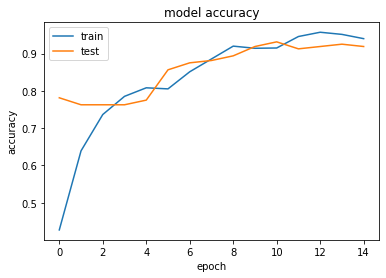

In [10]:
import matplotlib.pyplot as plt
print(history_object.history.keys())
plt.plot(history_object.history['accuracy'])
plt.plot(history_object.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

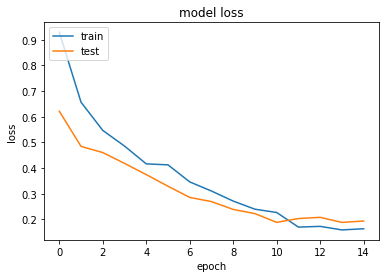

In [11]:
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()